**Comparative Analysis of Hyperparameter-Tuned Optimised Deep Learning Algorithms to Predict Stock Market Prices**

**Implementation of FFNN, CNN, LSTM and GRU with hypermeter tuning**

In [1]:
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

**Load data**

In [3]:
data = yf.download('AAPL', start='2019-01-01', end='2025-01-01')
#data = yf.download('GOOG', start='2019-01-01', end='2025-01-01')
#data = yf.download('TSLA', start='2019-01-01', end='2025-01-01')

/tmp/ipython-input-3-3763864439.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2019-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


**Price change, Simple Moving Average SMA 30 and 50**

In [4]:
data.reset_index(inplace=True)

data['Price_Change'] = (data['High'] - data['Low']) / data['Close']
data['SMA_30'] = data['Close'].rolling(window=30).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data.fillna(0, inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'SMA_30', 'SMA_50']
target = 'Close'


In [5]:
print(data[features])

Price         Open        High         Low       Close     Volume  \
Ticker        AAPL        AAPL        AAPL        AAPL       AAPL   
0        36.896084   37.839391   36.738866   37.617855  148158800   
1        34.297229   34.711713   33.825578   33.870838  365248800   
2        34.428238   35.385836   34.254347   35.316753  234428400   
3        35.421577   35.452545   34.754593   35.238155  219111200   
4        35.626428   36.164781   35.378693   35.909897  164101200   
...            ...         ...         ...         ...        ...   
1505    254.875189  257.588630  254.675658  257.578674   23234700   
1506    257.568678  259.474086  257.010028  258.396667   27237100   
1507    257.209530  258.077462  252.451019  254.974930   42355300   
1508    251.623005  252.889953  250.146571  251.593079   35557500   
1509    251.832511  252.670486  248.829744  249.817368   39480700   

Price  Price_Change      SMA_30      SMA_50  
Ticker                                       
0         

In [6]:
print(data[[target]])

Price        Close
Ticker        AAPL
0        37.617855
1        33.870838
2        35.316753
3        35.238155
4        35.909897
...            ...
1505    257.578674
1506    258.396667
1507    254.974930
1508    251.593079
1509    249.817368

[1510 rows x 1 columns]


**Scaling**

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

time_steps = 50
X, y = create_sequences(scaled_data, time_steps)


**Data Split**

In [8]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
print(X_train.shape)
print(X_test.shape)

(1168, 50, 8)
(292, 50, 8)


**Plot Closing Price with SMA_30 and SMA_50**

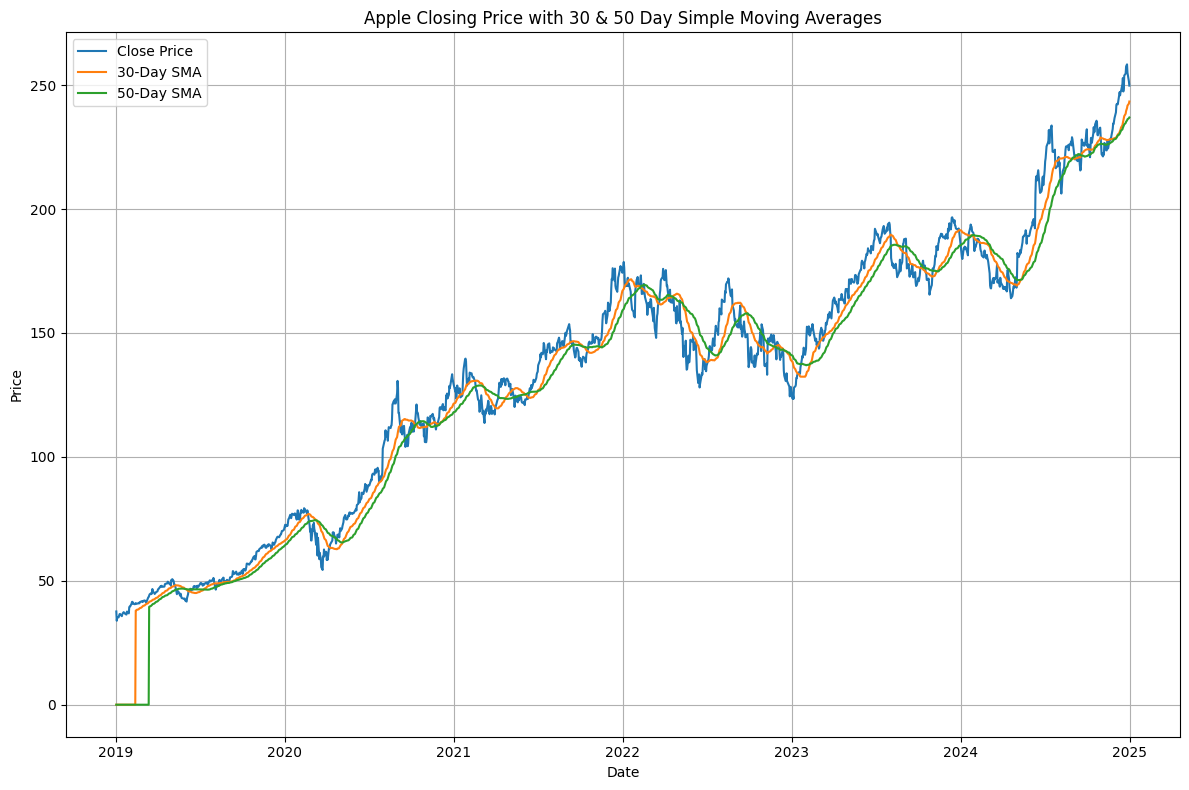

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['SMA_30'], label='30-Day SMA')
plt.plot(data['Date'], data['SMA_50'], label='50-Day SMA')
plt.title('Apple Closing Price with 30 & 50 Day Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Train and Test 4 Models in a single function**

In [11]:
def build_and_train_model(model_type):
    if model_type == 'FFNN':
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'CNN':
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'LSTM':
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.3),
            LSTM(64, return_sequences=False),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'GRU':
        model = Sequential([
            GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.3),
            GRU(64, return_sequences=False),
            Dropout(0.3),
            Dense(1)
        ])

    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    # Stop if
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # rescale
    if model_type == 'FFNN':
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
        X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    else:
        X_train_reshaped, X_test_reshaped = X_train, X_test

    # tuning parameters
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=100,
        batch_size=16,
        validation_data=(X_test_reshaped, y_test),
        callbacks=[early_stopping]
    )


    predicted = model.predict(X_test_reshaped)
    y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
    predicted_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted), len(features))), predicted), axis=1))[:, -1]

    # Evaluate MetricsAA
    mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_rescaled))
    mape = mean_absolute_percentage_error(y_test_rescaled, predicted_rescaled)
    r2 = r2_score(y_test_rescaled, predicted_rescaled)

    print(f"{model_type} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}")

    # Plot Results
    actual_full = data['Close'].values
    actual_test = y_test_rescaled
    predicted_test = predicted_rescaled

    # 1D array
    predicted_full = np.full(len(actual_full), np.nan, dtype=np.float64)
    predicted_full[-len(predicted_test):] = predicted_test

    plt.figure(figsize=(14, 7))
    plt.plot(actual_full, label='Full Dataset Actual', linewidth=2)
    plt.plot(range(len(actual_full) - len(actual_test), len(actual_full)), actual_test, label='Test Actual', linewidth=2)
    plt.plot(range(len(actual_full) - len(predicted_test), len(actual_full)), predicted_test, label=f'{model_type} Predicted', linewidth=2)
    plt.title(f'Full Dataset, Test Actual, and Predicted Prices ({model_type})')
    plt.xlabel('Time Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

print("Function Ready")

Function Ready


**Run model**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9612 - val_loss: 0.6905
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2063 - val_loss: 0.1503
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1104 - val_loss: 0.1676
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1019 - val_loss: 0.2802
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0927 - val_loss: 0.0430
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0699 - val_loss: 0.1257
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0702 - val_loss: 0.1361
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - val_loss: 0.0297
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676 - val_loss: 0.0749
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0586 - val_loss: 0.0715
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0509 - val_loss: 0.0311
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0605 - val_lo

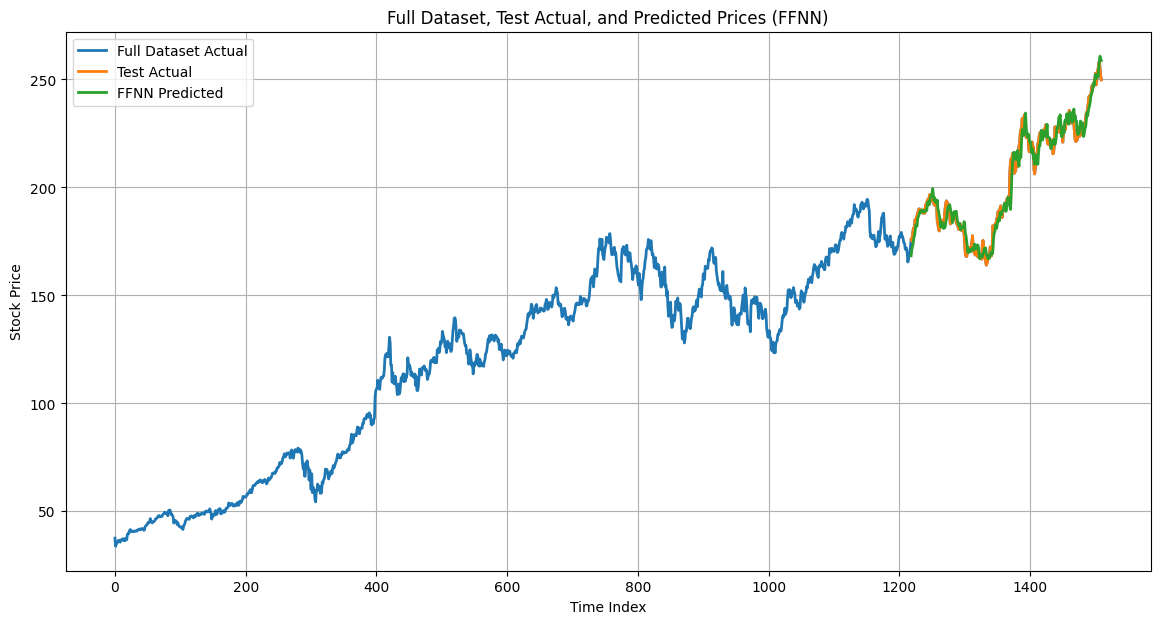

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1111 - val_loss: 0.0765
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0913 - val_loss: 0.0706
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0886 - val_loss: 0.0823
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0626 - val_loss: 0.1279
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0482 - val_loss: 0.1275
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0431 - val_loss: 0.0389
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0447 - val_loss: 0.1032
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - val_loss: 0.0167
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0425 - val_loss: 0.0259
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0356 - val_loss: 0.0150
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364 - val_loss: 0.0280
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0352 - val_l

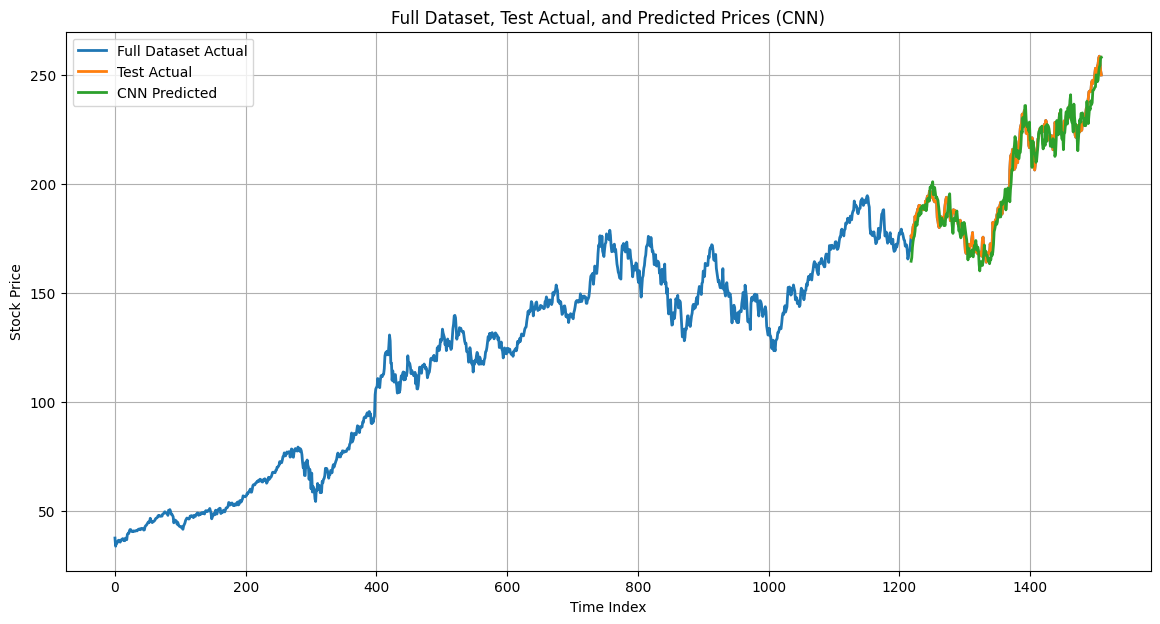

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0986 - val_loss: 0.0468
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0245 - val_loss: 0.0297
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0224 - val_loss: 0.0771
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0182 - val_loss: 0.0645
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0186 - val_loss: 0.0181
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0147 - val_loss: 0.0423
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0176 - val_loss: 0.0529
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0144 - val_loss: 0.0131
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0132 - val_loss: 0.0594
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0

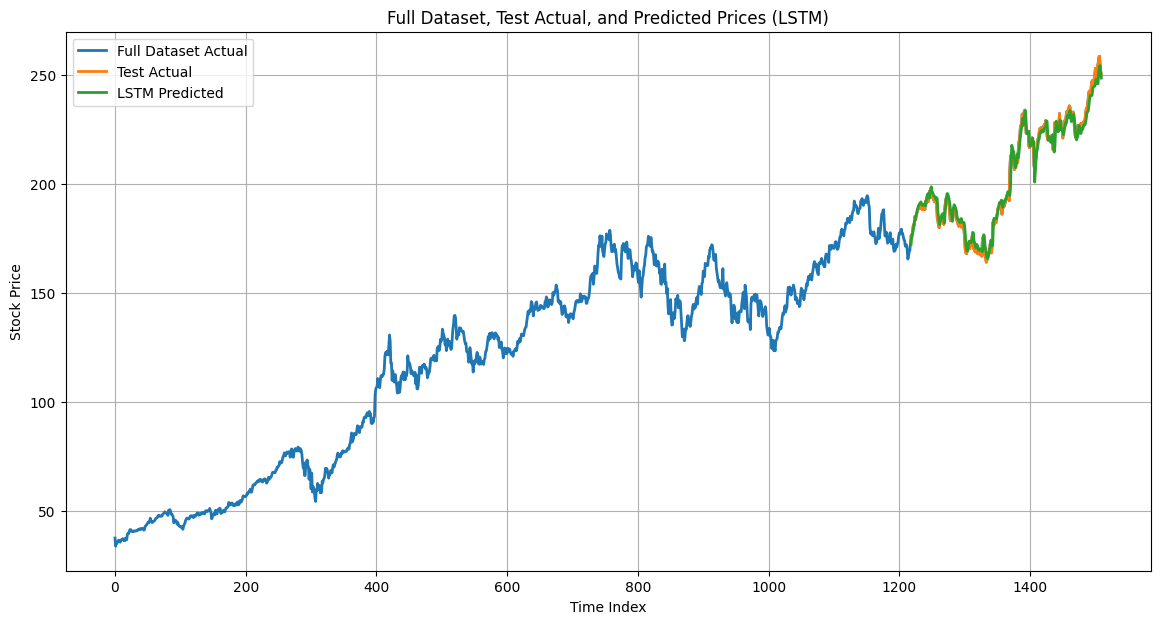

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0975 - val_loss: 0.0607
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0284 - val_loss: 0.0384
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0271 - val_loss: 0.0063
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0199 - val_loss: 0.0074
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0208 - val_loss: 0.0173
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0175 - val_loss: 0.0142
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0147 - val_loss: 0.0091
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0144 - val_loss: 0.0082
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0147 - val_loss: 0.0091
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0178 - val_loss: 0.0059
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0

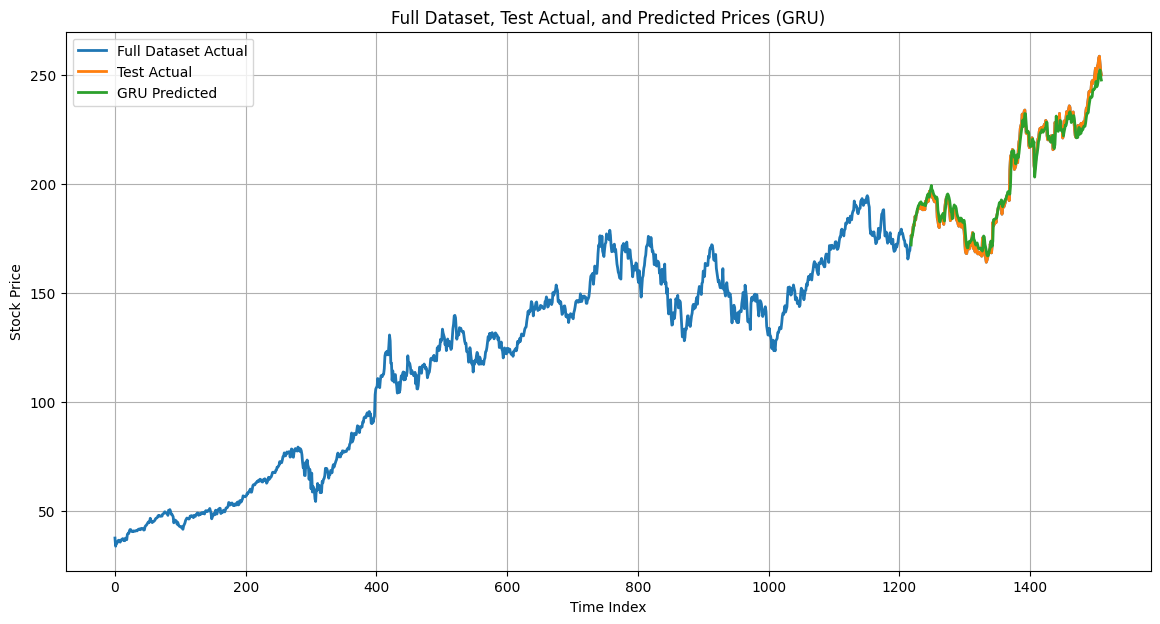

In [12]:
for model_type in ['FFNN', 'CNN', 'LSTM', 'GRU']:
    build_and_train_model(model_type)